In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
import pandas as pd
#import seaborn as sns
import numpy as np
import uuid

In [2]:
from rdflib import ConjunctiveGraph, Graph, Namespace, URIRef, Literal
import rdflib
XSD = Namespace('http://www.w3.org/2001/XMLSchema#')

In [3]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

print(tf.__version__)

2.3.0


In [4]:
import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling

import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [5]:
def build_and_compile_model(norm):
    model = keras.Sequential([
        norm,
        layers.Dense(64, activation='relu'),
        layers.Dense(64, activation='relu'),
        layers.Dense(1)
    ])

    model.compile(
        loss='mse',
        optimizer=tf.keras.optimizers.Adam(0.001),
        # use complete metric names
        metrics=['mean_absolute_error', 'mean_squared_error'])
    return model


def build_model(input_size):
  model = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=[input_size]),
    layers.Dense(64, activation='relu'),
    layers.Dense(1)
  ])

  optimizer = tf.keras.optimizers.RMSprop(0.001)

  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse']) # 'acc', tf.keras.metrics.MeanSquaredError()

  return model

""" displays prediction diagram by applying model of source room to 
data of target room
"""
def prediction_graph(source_room, target_room):
    
    test_predictions = rooms[source_room]['model'].predict(rooms[target_room]['normed_test_data']).flatten()

    a = plt.axes(aspect='equal')
    plt.scatter(rooms[target_room]['test_labels'], test_predictions)
    plt.xlabel('True Values [Occupants]')
    plt.ylabel('Predictions [Occupants]')
    lims = [0, 80]
    plt.xlim(lims)
    plt.ylim(lims)
    _ = plt.plot(lims, lims)

In [6]:
""" Merge time columns based on given interval
"""
def merge_time(input_df, data_column, interval = 30, time_filter = True):
    input_df['merged_time'] = input_df.apply(lambda row: str(row['year']) +
                         str(row['month']).zfill(2) + 
                         str(row['day']).zfill(2) +
                         row['time'][:2] + 
                         str(int(row['time'][3:5]) // interval).zfill(2), axis=1)
    
    if time_filter:
        drop_index = input_df[input_df['time'].map(lambda row: int(row[:2]) < 6 or int(row[:2]) > 14)].index
        input_df.drop(drop_index , inplace=True)
    
    
    return input_df.groupby(['merged_time'])[data_column].mean()
    

""" normalize data
"""
def norm_xxx(x, x_stats):
  return (x - x_stats['mean']) / x_stats['std']
    
    
""" build dataset from raw data
"""
def build_dataset(room):

    ### filled
    occupancy_file = "/Users/amin/Downloads/Dataset/filleddata/occupant_count_room_%d.csv"%room
    co2_file = "/Users/amin/Downloads/Dataset/filleddata/co2_room_%d.csv"%room
    temperature_file = "/Users/amin/Downloads/Dataset/filleddata/temperature_room_%d.csv"%room
    #illuminance_file = "/Users/amin/Downloads/Dataset/filleddata/Illuminance_room_%d.csv"%room
    humidity_file = "/Users/amin/Downloads/Dataset/filleddata/humidity_room_%d.csv"%room

    ### original
    #occupancy_file = "/Users/amin/Downloads/Dataset/original/occupant_count_room_1.csv"
    #co2_file = "/Users/amin/Downloads/Dataset/original/co2_room_1.csv"

    occ_columns = ['year', 'month', 'time', 'day', 'workday', 'occupancy']
    co2_columns = ['year', 'month', 'time', 'day', 'workday', 'co2']
    #tmp_columns = ['year', 'month', 'time', 'day', 'workday', 'temperature']
    #ill_columns = ['year', 'month', 'time', 'day', 'workday', 'illuminance']
    #hum_columns = ['year', 'month', 'time', 'day', 'workday', 'humidity']

    occ_df = pd.read_csv(occupancy_file, names=occ_columns, skiprows=1)
    co2_df = pd.read_csv(co2_file, names=co2_columns, skiprows=1)
    #tmp_df = pd.read_csv(temperature_file, names=tmp_columns, skiprows=1)
    #ill_df = pd.read_csv(illuminance_file, names=ill_columns, skiprows=1)
    #hum_df = pd.read_csv(humidity_file, names=hum_columns, skiprows=1)
    
    
    occ_grouped = merge_time(occ_df, 'occupancy')
    co2_grouped = merge_time(co2_df, 'co2')
    #tmp_grouped = merge_time(tmp_df, 'temperature')
    #ill_grouped = merge_time(ill_df, 'illuminance')
    #hum_grouped = merge_time(hum_df, 'humidity')
    
    
    #dataset = pd.concat([occ_grouped, co2_grouped, tmp_grouped, ill_grouped, hum_grouped], axis=1, sort=False)
    dataset = pd.concat([occ_grouped, co2_grouped], axis=1, sort=False)
    dataset['occupancy'] = dataset['occupancy'].round()

    # simplifying occupancy in 10X groups 
    #dataset['occupancy'] = dataset['occupancy']//10


    # simplifying occupancy in 20X groups 
    #dataset['occupancy'] = dataset['occupancy']//20

    # simplifying occupancy in 5X groups 
    #dataset['occupancy'] = dataset['occupancy']//5 
    
    return dataset

In [10]:
room_id = 1
dataset = room_dataset[room_id].copy()
train_dataset = dataset.sample(frac=0.8,random_state=0)
test_dataset = dataset.drop(train_dataset.index)

# dataset statistics
train_stats = train_dataset.describe()
train_stats.pop("occupancy")
train_stats = train_stats.transpose()
print(train_stats)

#split featured from lables
train_labels = train_dataset.pop('occupancy')
test_labels = test_dataset.pop('occupancy')

# normalize the data
normed_train_data = norm(train_dataset, train_stats)
normed_test_data = norm(test_dataset, train_stats)

     count        mean         std         min        25%         50%  \
co2  634.0  646.489927  133.201777  450.613337  521.43466  634.767994   

           75%         max  
co2  757.16534  992.810677  


In [11]:
model = build_model(len(train_dataset.keys()))
model.summary()

EPOCHS = 1000

# The patience parameter is the amount of epochs to check for improvement
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

history = model.fit(normed_train_data, train_labels, 
                    epochs=EPOCHS, validation_split = 0.2, verbose=0, 
                    callbacks=[early_stop, tfdocs.modeling.EpochDots()])


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                128       
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 4,353
Trainable params: 4,353
Non-trainable params: 0
_________________________________________________________________

Epoch: 0, acc:0.1203,  loss:807.5320,  mae:20.1766,  mse:807.5320,  val_acc:0.0315,  val_loss:806.8320,  val_mae:20.1976,  val_mse:806.8320,  
..........................................................................

In [12]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mae,mse,acc,val_loss,val_mae,val_mse,val_acc,epoch
69,212.747009,10.358898,212.747009,0.100592,243.602295,11.286337,243.602295,0.031496,69
70,212.699753,10.388831,212.699753,0.100592,243.540222,11.277650,243.540222,0.031496,70
71,212.957581,10.399727,212.957581,0.100592,243.541702,11.306745,243.541702,0.031496,71
72,212.316315,10.388264,212.316315,0.100592,243.758057,11.234996,243.758057,0.031496,72
73,212.341553,10.381507,212.341553,0.100592,243.811005,11.228868,243.811005,0.031496,73


# Build datasets and models

In [240]:
# build datasets
room_dataset = {1: build_dataset(1), 2:build_dataset(2), 3:build_dataset(3)}

In [292]:
# build models
rooms = {}

for room_id in [1,2,3]:
    
    # build dataset
    dataset = room_dataset[room_id].copy()
    
    #train_dataset = dataset.sample(frac=0.8,random_state=0)
    #test_dataset = dataset.drop(train_dataset.index)

    test_dataset = dataset.sample(n=100,random_state=0)
    train_dataset = dataset.drop(test_dataset.index)
    finetune_dataset = train_dataset.sample(n=100,random_state=0)
    
    #retrain_dataset = dataset.sample(n=100,random_state=0)
    #retrain_labels = retrain_dataset.pop('occupancy')
    #rest_dataset = dataset.drop(retrain_dataset.index)
    #test_dataset = rest_dataset.sample(n=100,random_state=0)
    
    
    
    ds_uuid = uuid.uuid4().hex
    ds_file = 'dataset/ds_{}.h5'.format(ds_uuid)
    store = pd.HDFStore(ds_file)
    store['train'] = train_dataset
    store['finetune'] = finetune_dataset
    store['test'] = test_dataset
    store.close()
    

    #split featured from lables
    train_labels = train_dataset.pop('occupancy')
    test_labels = test_dataset.pop('occupancy')


    # normalization layer
    co2_feature = np.array(train_dataset['co2'])
    co2_normalizer = preprocessing.Normalization(input_shape=[1,])
    co2_normalizer.adapt(co2_feature)
    
    model = build_and_compile_model(co2_normalizer)
    
    
    #model.summary()

    EPOCHS = 1000

    # The patience parameter is the amount of epochs to check for improvement
    early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

    history = model.fit(train_dataset, train_labels, 
                        epochs=EPOCHS, validation_split = 0.2, verbose=0, 
                        callbacks=[early_stop, tfdocs.modeling.EpochDots()])
    
    # store model
    model_uuid = uuid.uuid4().hex
    
    print('Room_',room_id,'(ds_id: ', ds_uuid, ', model_id:', model_uuid, ')')
    
    model_file = 'model/model_{}.h5'.format(model_uuid)
    model.save(model_file)

    #loss, mae, mse, acc = model.evaluate(normed_test_data, test_labels, verbose=2)
    rooms[room_id] = {
        'test_data' : test_dataset, 
        'test_labels' : test_labels, 
        'model': model, 
        'model_file' : model_file, 
        'dataset_uuid': ds_uuid,
        'model_uuid': model_uuid
    }


Epoch: 0, loss:846.9637,  mean_absolute_error:21.6645,  mean_squared_error:846.9637,  val_loss:583.5036,  val_mean_absolute_error:14.3402,  val_mean_squared_error:583.5036,  
.................Room_ 1 (ds_id:  b782a3a359e54fcebbd57d590665bc39 , model_id: 0754017c705548d490065f71ac4364ee )

Epoch: 0, loss:160.7701,  mean_absolute_error:9.5912,  mean_squared_error:160.7701,  val_loss:81.8918,  val_mean_absolute_error:7.0348,  val_mean_squared_error:81.8918,  
..................................Room_ 2 (ds_id:  49117df88973460f947218e5f0adb18e , model_id: 24e6a2b6b9c64aec9605bc00b2ed3b5a )

Epoch: 0, loss:183.0975,  mean_absolute_error:9.5052,  mean_squared_error:183.0975,  val_loss:99.0436,  val_mean_absolute_error:7.6095,  val_mean_squared_error:99.0436,  
................Room_ 3 (ds_id:  fa639abdd2e940149afd422aab51e5d8 , model_id: cac90a7b1bf147bda94625edc5b339f7 )


Text(0, 0.5, 'MAE [Occupants]')

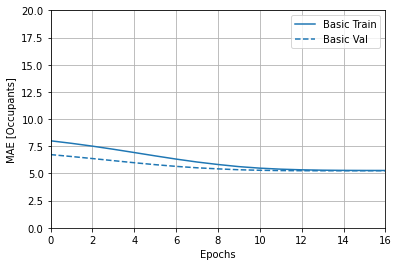

In [575]:
plotter = tfdocs.plots.HistoryPlotter(smoothing_std=2)
plotter.plot({'Basic': history}, metric = 'mean_absolute_error')
plt.ylim([0, 20])
plt.ylabel('MAE [Occupants]')

In [244]:
room_id = 3
loss, mae, mse = rooms[room_id]['model'].evaluate(rooms[room_id]['test_data'], rooms[room_id]['test_labels'], verbose=2)
print("Testing set Mean Abs Error: {:5.2f} CO2".format(mae))

4/4 - 0s - loss: 40.5253 - mean_absolute_error: 5.0246 - mean_squared_error: 40.5253
Testing set Mean Abs Error:  5.02 CO2


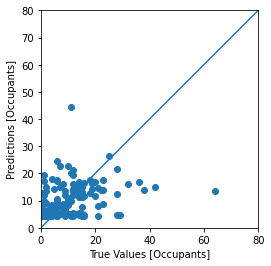

In [585]:
test_predictions = model.predict(rooms[room_id]['test_data']).flatten()

a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [Occupants]')
plt.ylabel('Predictions [Occupants]')
lims = [0, 80]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

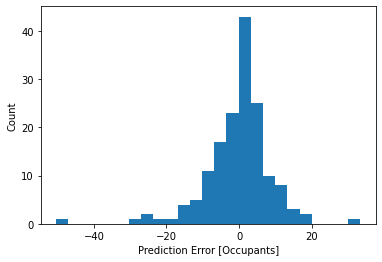

In [586]:
#error = test_predictions - test_labels
error = test_predictions - rooms[room_id]['test_labels']
plt.hist(error, bins = 25)
plt.xlabel("Prediction Error [Occupants]")
_ = plt.ylabel("Count")

In [37]:
dataset.isna().sum()

occupancy      0
co2            0
temperature    0
humidity       0
dtype: int64

In [ ]:
# Preparing dataset for overlay SNS diagram
room1_dataset = room_dataset[1].copy()
room2_dataset = room_dataset[2].copy()
room3_dataset = room_dataset[3].copy()

room1_dataset['room'] = 1
room2_dataset['room'] = 2
room3_dataset['room'] = 3

dataset=room1_dataset.copy()
dataset = dataset.append(room2_dataset)
dataset = dataset.append(room3_dataset)

sns.pairplot(dataset, diag_kind="kde", hue="room",  plot_kws=dict(alpha=0.2))

<Figure size 432x288 with 0 Axes>

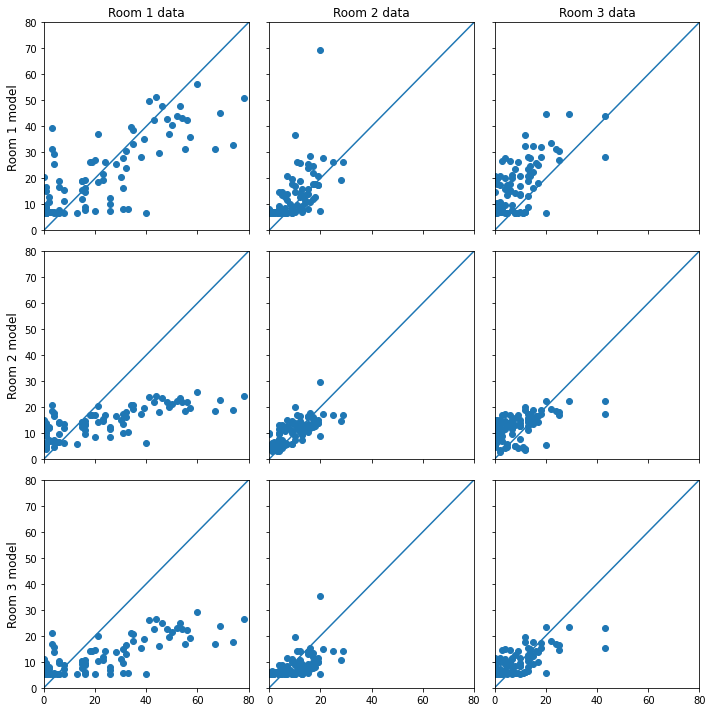

In [261]:
# Drawing prediction subplots
fig = plt.figure()
fig, axs = plt.subplots(3, 3, sharex=True, sharey=True, figsize=(10, 10))

lims = [0, 80]
plt.xlim(lims)
plt.ylim(lims)

cols = ['Room 1 data', 'Room 2 data', 'Room 3 data']
rows = ['Room 1 model', 'Room 2 model', 'Room 3 model']

for ax, col in zip(axs[0], cols):
    ax.set_title(col)

for ax, row in zip(axs[:,0], rows):
    ax.set_ylabel(row, size='large')

fig.tight_layout()


for source_room in [1,2,3]:
    for target_room in [1,2,3]:
        test_predictions = rooms[source_room]['model'].predict(rooms[target_room]['test_data']).flatten()
        axs[source_room - 1 , target_room - 1].scatter(rooms[target_room]['test_labels'], test_predictions)
        _ = axs[source_room - 1 , target_room - 1].plot(lims, lims)
        #axs[source_room - 1, target_room -1].set_xlabel('True Values [Occupants]')
plt.show()

4/4 - 0s - loss: 167.9990 - mean_absolute_error: 9.7587 - mean_squared_error: 167.9990
4/4 - 0s - loss: 63.6485 - mean_absolute_error: 5.4978 - mean_squared_error: 63.6485
4/4 - 0s - loss: 129.4320 - mean_absolute_error: 9.6490 - mean_squared_error: 129.4320
4/4 - 0s - loss: 327.7086 - mean_absolute_error: 13.4043 - mean_squared_error: 327.7086
4/4 - 0s - loss: 21.8347 - mean_absolute_error: 3.7022 - mean_squared_error: 21.8347
4/4 - 0s - loss: 65.6372 - mean_absolute_error: 6.6769 - mean_squared_error: 65.6372
4/4 - 0s - loss: 328.2416 - mean_absolute_error: 13.3242 - mean_squared_error: 328.2416
4/4 - 0s - loss: 34.1794 - mean_absolute_error: 4.6656 - mean_squared_error: 34.1794
4/4 - 0s - loss: 40.5407 - mean_absolute_error: 5.0176 - mean_squared_error: 40.5407


<Figure size 432x288 with 0 Axes>

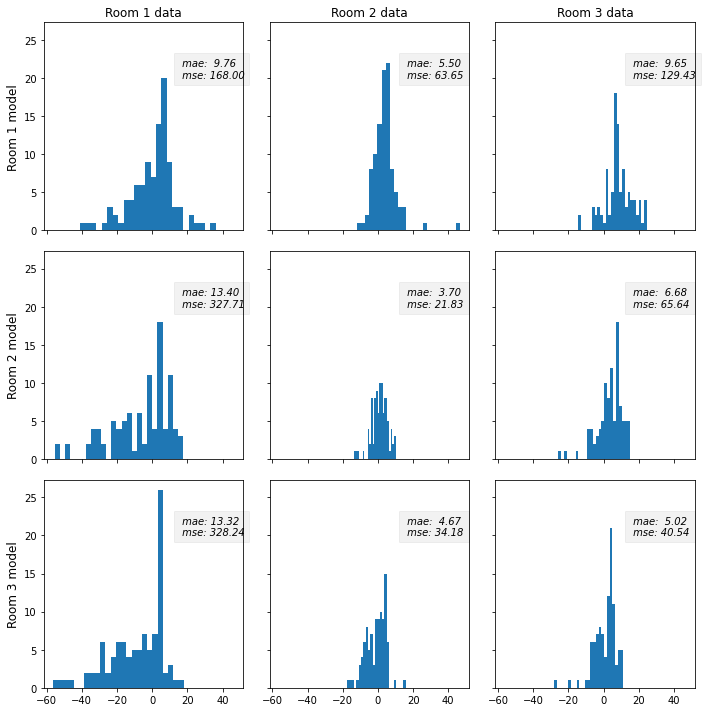

In [293]:
# Drawing error subplots
fig = plt.figure()
fig, axs = plt.subplots(3, 3, sharex=True, sharey=True, figsize=(10, 10))

cols = ['Room 1 data', 'Room 2 data', 'Room 3 data']
rows = ['Room 1 model', 'Room 2 model', 'Room 3 model']

for ax, col in zip(axs[0], cols):
    ax.set_title(col)

for ax, row in zip(axs[:,0], rows):
    ax.set_ylabel(row, size='large')

fig.tight_layout()

cnt = 1
for source_room in [1,2,3]:
    
    source_model = rooms[source_room]['model']

    for target_room in [1,2,3]:
        
        loss, mae, mse = source_model.evaluate(rooms[target_room]['test_data'], rooms[target_room]['test_labels'], verbose=2)
        axs[source_room - 1 , target_room - 1].text(15, 20, ' mae: {:5.2f} \n mse: {:5.2f}'.format(mae, mse), style='italic',
            bbox={'facecolor': 'black', 'alpha': 0.05, 'pad': 5})
        
        test_predictions = source_model.predict(rooms[target_room]['test_data']).flatten()
        error = test_predictions - rooms[target_room]['test_labels'] 
        axs[source_room - 1 , target_room - 1].hist(error, bins = 25)
        
        #plt.xlabel("Prediction Error [Occupants]")
        #_ = plt.ylabel("Count")
        cnt += 1
    
        
plt.show()

In [35]:
{m.name: m.result() for m in tf_model.metrics}

{'loss': <tf.Tensor: shape=(), dtype=float32, numpy=48.950825>,
 'mae': <tf.Tensor: shape=(), dtype=float32, numpy=5.2487955>,
 'mse': <tf.Tensor: shape=(), dtype=float32, numpy=48.950825>,
 'acc': <tf.Tensor: shape=(), dtype=float32, numpy=0.10236221>}

In [32]:
tf_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 64)                128       
_________________________________________________________________
dense_7 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 65        
Total params: 4,353
Trainable params: 4,353
Non-trainable params: 0
_________________________________________________________________


# Add Model to Ontology

In [15]:
#RDF        = Namespace('http://www.w3.org/1999/02/22-rdf-syntax-ns#')
#RDFS       = Namespace('http://www.w3.org/2000/01/rdf-schema#')
#OWL        = Namespace('http://www.w3.org/2002/07/owl#')
#XML        = Namespace('http://www.w3.org/XML/1998/namespace')
#XSD        = Namespace('http://www.w3.org/2001/XMLSchema#')
#DCTERMS    = Namespace('http://purl.org/dc/terms/')

#BRICK      = Namespace('https://brickschema.org/schema/1.0.3/Brick#')
#BRICKFRAME = Namespace('https://brickschema.org/schema/1.0.3/BrickFrame#')
#BRICKTAG   = Namespace('https://brickschema.org/schema/1.0.3/BrickTag#')
#BRICKUSE   = Namespace('https://brickschema.org/schema/1.0.3/BrickUse#')

#MLS        = Namespace('http://www.w3.org/ns/mls#')

#NS         = Namespace('http://inter-space.org/learning_model#')

In [70]:
class Ontology:

    # prefixes
    NS = {
        'rdf'        : Namespace('http://www.w3.org/1999/02/22-rdf-syntax-ns#'),
        'rdfs'       : Namespace('http://www.w3.org/2000/01/rdf-schema#'),
        'owl'        : Namespace('http://www.w3.org/2002/07/owl#'),
        'xml'        : Namespace('http://www.w3.org/XML/1998/namespace'),
        'xsd'        : Namespace('http://www.w3.org/2001/XMLSchema#'),
        'dcterms'    : Namespace('http://purl.org/dc/terms/'),
        'brick'      : Namespace('https://brickschema.org/schema/1.0.3/Brick#'),
        'brickframe' : Namespace('https://brickschema.org/schema/1.0.3/BrickFrame#'),
        'bricktag'   : Namespace('https://brickschema.org/schema/1.0.3/BrickTag#'),
        'brickuse'   : Namespace('https://brickschema.org/schema/1.0.3/BrickUse#'),
        'mls'        : Namespace('http://www.w3.org/ns/mls#'),
        'isl'        : Namespace('http://inter-space.org/learning_model#')
    }
    
    
    
    metrics = {
        'mae': 'MeanAbsoluteError',
        'mean_absolute_error': 'MeanAbsoluteError',

        'mse': 'MeanSquaredError',
        'mean_squared_error': 'MeanSquaredError'
    }

    
    def __init__(self, conjunctive = True):
        
        if conjunctive: 
            # create conjunctive graph for NQuads serialization
            self.g = ConjunctiveGraph()
        else:
            self.g = Graph()

        for prefix in self.NS:
            self.g.bind(prefix, self.NS[prefix])
            
        # add all building-nutral triples
        # TODO: later add to base.ttl and load it.
        #for elm in [self.NS['mls'].MinValue, self.NS['mls'].MaxValue, self.NS['mls'].StdValue, self.NS['mls'].MeanValue]:
        #    self.g.add((elm, self.NS['rdf'].type, self.NS['owl'].Class))
        #    self.g.add((elm, self.NS['rdfs'].subClassOf, self.NS['mls'].FeatureCharacteristic))

        
    def load_ttl(self, ttl_file):
        self.g.parse(ttl_file, format="turtle")
          
            
    def get_uuid(self):
        return uuid.uuid4().hex
    
    
    def get_building(self):
        return next(self.g.subjects(self.NS['rdf'].type, self.NS['brick'].Building))
    
    
    def add_space(self, room_name, statements):
        space = self.NS['isl'][room_name]
        self.g.add((space, RDF.type, self.NS['brick'].Room))
        
        for p,o in statements:
            self.g.add((space, self.entity(p), self.entity(o)))
        
        building = self.get_building()
        self.g.add((building, self.NS['brickframe'].Contains, space))
        return space
        
        
    def add_sensor(self, sensor_name, statements):
        sensor = self.NS['isl'][sensor_name]
        
        for p,o in statements:
            self.g.add((sensor, self.entity(p), self.entity(o)))
        
        
        
    
    """ 
    Run is an ML flow that applies a model in a specific dataset to achive the given task.
    If it is a trainig run, there wis no input model. Input model is for evaluation and 
    test purposes. 
        - test_metrics: metrics of the test run. For adding a trained model should be None
        - built_on: in case of transfer learning, adds the original model
        
    TODO: remove evaluations for training phase
        
    """    
    def add_run(self,  model_filename, task_name, split_id, test_metrics = None, built_on = None):
        
        #train_run = split_id.endswith('/train')
        train_run = test_metrics is None
        
        # tensorflow model
        tf_model = tf.keras.models.load_model(model_filename)
        
        # model
        model_id = self.__extract_id(model_filename)
        model = self.NS['isl'][model_id]
        run_id = 'run_' + self.get_uuid()
        
        model_run = self.NS['isl'][run_id]
        self.g.add((model_run, self.NS['rdf'].type, self.NS['mls'].Run))
        
        
        if train_run:
            self.g.add((model, self.NS['rdf'].type, self.NS['mls'].Model))
            self.g.add((model, self.NS['dcterms'].identifier, Literal(model_filename)))
            self.g.add((model_run, self.NS['mls'].hasOutput, model))
            
            if built_on:
                self.g.add((model, self.NS['mls'].builtOn, self.NS['isl']['model_'+built_on]))
        else:

            self.g.add((model_run, self.NS['mls'].hasInput, model))
            
            # model evaluations
            eval_id = run_id + '/eval'
            model_evaluation = self.NS['isl'][eval_id]
            self.g.add((model_evaluation, self.NS['rdf'].type, self.NS['mls'].ModelEvaluation))


            # metrics will be added for test runs
            for m in tf_model.metrics:
                if m.name in self.metrics:
                    metric_name = self.metrics[m.name]
                    metric_class = self.NS['mls'][metric_name]

                    metric = self.NS['isl'][eval_id + '/' + m.name]
                    self.g.add((metric, self.NS['rdf'].type, metric_class))
                    self.g.add((metric, self.NS['mls'].hasValue, Literal(test_metrics[m.name], datatype=self.NS['xsd'].float) ))
                    self.g.add((model_evaluation, self.NS['mls'].specifiedBy, metric))
                    
            self.g.add((model_run, self.NS['mls'].hasOutput, model_evaluation))

        
        # task
        task = self.NS['isl'][task_name]
        self.g.add((model_run, self.NS['mls'].achieves, task))
        
        self.g.add((model_run, self.NS['mls'].hasInput, self.NS['isl'][split_id]))
        self.g.add((model_run, self.NS['mls'].executes, self.NS['isl']['tensorflow']))
        
        backend = type(tf_model).__module__+'.'+type(tf_model).__name__
        self.g.add((model_run, self.NS['mls'].realizes, Literal(backend)))
        
        return model_run
        
    
    """
    Receive the dataset as dataframe and add it to ontology. 
    Also the references to BRICK entities (e.g. datatype and sensors) can be added.
    """
    def add_dataset(self, ds_id, brick_refs=None):
        
        stats_dic = {
            'min': {'class': self.NS['mls'].MinValue, 'datatype': self.NS['xsd'].float },
            'max': {'class': self.NS['mls'].MaxValue, 'datatype': self.NS['xsd'].float },
            'mean': {'class': self.NS['mls'].MeanValue, 'datatype': self.NS['xsd'].float },
            'std': {'class': self.NS['mls'].StdValue, 'datatype': self.NS['xsd'].float }
        }
        
        split_dict = {
            'test' : 'TestDataset',
            'train': 'TrainDataset',
            'finetune': 'FineTuningDataset',
            'validation': 'ValidationDataset'
        }

        dataset_filename = 'dataset/ds_{}.h5'.format(ds_id)
        
        ds = pd.HDFStore(dataset_filename, 'r')
        split_keys = [k[1:] for k in ds.keys()]
        
        # get structure from the first data split
        key0 = split_keys[0]

        dataset_uri = self.NS['isl'][ds_id]
        self.g.add((dataset_uri, self.NS['rdf'].type, self.NS['mls'].Dataset))
        
        
        for col in ds[key0].columns:
            
            feature = self.NS['isl'][ds_id+'/'+col]
            self.g.add((feature, self.NS['rdf'].type, self.NS['mls'].Feature))
            self.g.add((dataset_uri, self.NS['mls'].hasPart, feature))

            
            # add brick references if any
            if brick_refs and col in brick_refs:
                statements = brick_refs[col]
                for p,o in statements:
                    self.g.add((feature, self.entity(p), self.entity(o)))
                

        
        # add dataset splits    
        for key in split_keys:
            # add split definition
            split_id = ds_id + '/' + key
            split = self.NS['isl'][split_id]
            split_class = split_dict[key]
            self.g.add((split, self.NS['rdf'].type, self.NS['mls'][split_class]))
            self.g.add((dataset_uri, self.NS['mls'].hasSplit, split))
            
           
            # add number of instances to dataset split
            rows, _ = ds[key].shape
            val = self.NS['isl'][split_id+'/'+'count']
            self.g.add((val, self.NS['rdf'].type, self.NS['mls'].DatasetCharacteristic))
            self.g.add((val, self.NS['mls'].hasValue, Literal(rows, datatype=self.NS['xsd'].long) ))
            self.g.add((split, self.NS['mls'].hasQuality, val))

        
            stats = ds[key].describe()
            
            for col in ds[key].columns:
                column = self.NS['isl'][split_id+'/'+col]
                feature = self.NS['isl'][ds_id+'/'+col]
                
                self.g.add((column, self.NS['rdf'].type, self.NS['mls'].Column))
                self.g.add((column, self.NS['mls'].specifiedBy, feature))


                for ind in stats_dic: # stat indicators

                    # quality indicators
                    val = self.NS['isl'][split_id+'/'+col+'/'+ind]
                    self.g.add((val, self.NS['rdf'].type, stats_dic[ind]['class']))
                    self.g.add((val, self.NS['mls'].hasValue, Literal(stats[col][ind], datatype=stats_dic[ind]['datatype']) ))

                    self.g.add((column, self.NS['mls'].hasQuality, val))
                    
        ds.close()
        return


    """ extract entity id from filename
    """
    def __extract_id(self, filename):
        start = filename.rfind('/') + 1
        end = filename.rfind('.')
        return filename[start:end]




    """ Geneartes a qualified entity for the given name with prefix
    """
    def entity(self, name):
        if type(name) in [Literal, URIRef]:
            return name
        elif ':' in name:
            prefix, label = name.split(':')
            return self.NS[prefix][label]
        else:
            return Literal(name, datatype=self.NS['xsd'].string)
        
        
    def serialize(self):
        print(self.g.serialize(format='n3').decode("utf-8"))
        
    def save(self, file_name):
        formats = {
            'ttl': 'turtle',
            'nq':'nquads'
        }
        _, ext = file_name.split('.')
        
        if ext == 'ttl':
            self.g.serialize(destination='ontology/'+file_name, format=formats[ext])
            
        elif ext =='nq':
            # shorten namespaces and remove graph part
            st = self.g.serialize(format=formats[ext]).decode("utf-8")

            for title in self.NS:
                st = st.replace(str(self.NS[title]), title+':')

            lines = st.split('\n')

            with open('ontology/'+file_name, 'w') as f:
                for line in lines:
                    elms = line.split(' ')
                    cnt = len(elms)
                    if cnt  > 2:
                        f.write(' '.join(elms[:cnt-2]) + ' .\n')        
                        
        else:
            print('Unknown file extension!')
            

            


In [471]:
ont = Ontology()
ont.load_ttl('ontology/base_graph.ttl')
#ont.add_dataset(train_dataset)

In [472]:
for room_id, room in rooms.items():
    
    #dataset = room_dataset[room_id].copy()
    #train_dataset = dataset.sample(frac=0.8,random_state=0)
    #test_dataset = dataset.drop(train_dataset.index)
    
    #ds_uuid = uuid.uuid4().hex
    #filename = 'dataset/ds_{}.h5'.format(ds_uuid)
    #store = pd.HDFStore(filename)
    #store['train'] = train_dataset
    #store['test'] = test_dataset
    #store.close()
    
    
    brick_ref = {
        'co2': [
            ('rdf:type', 'brick:CO2_Level'), 
            ('rdfs:label', 'Room CO2 Level'),
            ('brickframe:isMeasuredBy', 'isl:/co2_sensors/'+str(room_id))
        ],
        'occupancy': [
            ('rdf:type', 'brick:Occupancy'),
            ('rdfs:label', 'Room Occupancy'),
            ('brickframe:isMeasuredBy', 'isl:/occ_sensors/'+str(room_id))
        ] 
    }    
    

    
    ont.add_dataset(room['dataset_uuid'], brick_ref)
    
    #model_uuid = uuid.uuid4().hex
    #model_filename = 'model/model_{}.h5'.format(model_uuid)
    #rooms[room_id]['model'].save(model_filename)
    
    # add train run
    train_split_id = room['dataset_uuid'] + '/train'
    ont.add_run(room['model_file'], 'occupancy_task', train_split_id)


# add test runs (source room model + target room data)
for source_room in rooms:
    
    source_model = rooms[source_room]['model']

    for target_room in rooms:
        
        metric_values = source_model.evaluate(rooms[target_room]['test_data'], rooms[target_room]['test_labels'], verbose=2)
        metric_names = [m.name for m in source_model.metrics]
        metrics = dict(zip(metric_names, metric_values))

        test_split_id = rooms[target_room]['dataset_uuid'] + '/test'
        ont.add_run(rooms[source_room]['model_file'], 'occupancy_task', test_split_id, metrics)
    

4/4 - 0s - loss: 167.9990 - mean_absolute_error: 9.7587 - mean_squared_error: 167.9990
4/4 - 0s - loss: 63.6485 - mean_absolute_error: 5.4978 - mean_squared_error: 63.6485
4/4 - 0s - loss: 129.4320 - mean_absolute_error: 9.6490 - mean_squared_error: 129.4320
4/4 - 0s - loss: 327.7086 - mean_absolute_error: 13.4043 - mean_squared_error: 327.7086
4/4 - 0s - loss: 21.8347 - mean_absolute_error: 3.7022 - mean_squared_error: 21.8347
4/4 - 0s - loss: 65.6372 - mean_absolute_error: 6.6769 - mean_squared_error: 65.6372
4/4 - 0s - loss: 328.2416 - mean_absolute_error: 13.3242 - mean_squared_error: 328.2416
4/4 - 0s - loss: 34.1794 - mean_absolute_error: 4.6656 - mean_squared_error: 34.1794
4/4 - 0s - loss: 40.5407 - mean_absolute_error: 5.0176 - mean_squared_error: 40.5407


In [308]:
# Adding Amin's Room
space_info = [ 
    ('isl:hasArea', Literal('12', datatype=XSD.float)), 
    ('isl:hasUsage', 'Office')]
room = ont.add_space('/rooms/amin', space_info)


sensor_info = [
    ('brickframe:isPointOf', room), 
    ('rdf:type', 'brick:Luminance_Sensor'), 
    ('brickframe:hasMeasurement', Literal('ws://192.168.0.115:9001/light', datatype=XSD.string))] 
ont.add_sensor('/luminance_sensors/cpx_l', sensor_info)

     
sensor_info = [
    ('brickframe:isPointOf', room), 
    ('rdf:type', 'brick:Temperature_Sensor'), 
    ('brickframe:hasMeasurement', Literal('ws://192.168.0.115:9001/temperature', datatype=XSD.string))] 
ont.add_sensor('/temperature_sensors/cpx_t', sensor_info)
     


In [ ]:
ont.serialize()

In [407]:
ont.save('building_model_1.nq')

In [478]:
ont.save('building_model_1.ttl')

In [ ]:
#ds_id = '0d9a0f922a814f3298ee73b8b9c130e6'
room3_ds_id = 'ce357a6ce1ee45d1bc58596222f828a3'
dataset_filename = f'dataset/ds_{room3_ds_id}.h5'
room3_ds = pd.HDFStore(dataset_filename, 'r')

In [183]:
room3_model_id = 'a52818ed338744f2a6d9026f821f324e'
model_filename = f'model/model_{room3_model_id}.h5'
room3_model = tf.keras.models.load_model(model_filename)

In [13]:
tf_model.summary()

Model: "sequential_32"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization_29 (Normalizat (None, 1)                 3         
_________________________________________________________________
dense_96 (Dense)             (None, 64)                128       
_________________________________________________________________
dense_97 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_98 (Dense)             (None, 1)                 65        
Total params: 4,356
Trainable params: 4,353
Non-trainable params: 3
_________________________________________________________________


In [ ]:
test_predictions = room3_model.predict(rooms[room_id]['test_data']).flatten()

a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [Occupants]')
plt.ylabel('Predictions [Occupants]')
lims = [0, 80]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

error = test_predictions - rooms[room_id]['test_labels']
plt.hist(error, bins = 25)
plt.xlabel("Prediction Error [Occupants]")
_ = plt.ylabel("Count")

In [145]:
metric_values = room3_model.evaluate(test_dataset['co2'], test_dataset['occupancy'], verbose=2)
metric_names = [m.name for m in room3_model.metrics]
metrics = dict(zip(metric_names, metric_values))
metrics

3/3 - 0s - loss: 44.2590 - mean_absolute_error: 5.3428 - mean_squared_error: 44.2590


{'loss': 44.25895309448242,
 'mean_absolute_error': 5.342784404754639,
 'mean_squared_error': 44.25895309448242}

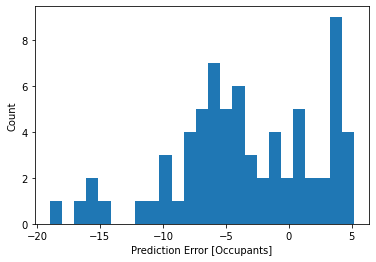

In [144]:
test_predictions = room3_model.predict(test_dataset['co2']).flatten()
error = test_predictions - test_dataset['occupancy']
plt.hist(error, bins = 25)
plt.xlabel("Prediction Error [Occupants]")
_ = plt.ylabel("Count")

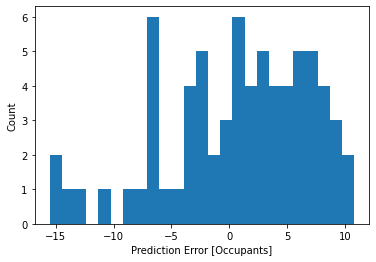

In [128]:
test_predictions = new_model.predict(test_dataset['co2']).flatten()
error = test_predictions - test_dataset['occupancy']
plt.hist(error, bins = 25)
plt.xlabel("Prediction Error [Occupants]")
_ = plt.ylabel("Count")

In [223]:
# TO BE DELETED
# retrain on room 2 data
dataset = room_dataset[2].copy()

#retrain_dataset = dataset.sample(frac=0.1,random_state=0)
retrain_dataset = dataset.sample(n=100,random_state=0)
retrain_labels = retrain_dataset.pop('occupancy')

rest_dataset = dataset.drop(retrain_dataset.index)

#test_dataset = rest_dataset.sample(frac=0.1,random_state=0)
test_dataset = rest_dataset.sample(n=100,random_state=0)


ds_uuid = uuid.uuid4().hex
ds_file = f'dataset/ds_{ds_uuid}.h5'
store = pd.HDFStore(ds_file)
store['train'] = retrain_dataset
store['test'] = test_dataset
store.close()
print('Retraing dataset added: ', ds_file)

ont.add_dataset(ds_uuid, brick_ref)


Retraing dataset added:  dataset/ds_aadd267319fe464286c4e70b68191924.h5


# Transfer Learning

In [474]:
# Take the model from room 2
model_room_id = 2

orig_model = rooms[model_room_id]['model']

# load again to repurpose
orig_model_id = rooms[model_room_id]['model_uuid']
orig_model_filename = f'model/model_{orig_model_id}.h5'

new_model = tf.keras.models.load_model(orig_model_filename)

new_model.compile(
    loss='mse',
    optimizer=tf.keras.optimizers.Adam(0.00001),
    #optimizer=keras.optimizers.Adam(1e-5),  # Low learning rate
    # use complete metric names
    metrics=['mean_absolute_error', 'mean_squared_error'])

In [475]:
# repurpose for room 3
ds_room_id = 3
ds_id = rooms[ds_room_id]['dataset_uuid']
dataset_filename = f'dataset/ds_{ds_id}.h5'
room_ds = pd.HDFStore(dataset_filename, 'r')

finetune_dataset = room_ds['finetune'] 
finetune_labels = finetune_dataset.pop('occupancy')

test_dataset = room_ds['test'] 
room_ds.close()

In [476]:
EPOCHS = 1000

# The patience parameter is the amount of epochs to check for improvement
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

history = new_model.fit(finetune_dataset, finetune_labels, 
                    epochs=EPOCHS, validation_split = 0.2, verbose=0, 
                    callbacks=[early_stop, tfdocs.modeling.EpochDots()])


Epoch: 0, loss:69.2057,  mean_absolute_error:7.2603,  mean_squared_error:69.2057,  val_loss:44.3335,  val_mean_absolute_error:5.5014,  val_mean_squared_error:44.3335,  
....................................................................................................
Epoch: 100, loss:63.7513,  mean_absolute_error:6.9454,  mean_squared_error:63.7513,  val_loss:41.2549,  val_mean_absolute_error:5.2262,  val_mean_squared_error:41.2549,  
....................................................................................................
Epoch: 200, loss:59.9275,  mean_absolute_error:6.6961,  mean_squared_error:59.9275,  val_loss:39.1099,  val_mean_absolute_error:5.0424,  val_mean_squared_error:39.1099,  
....................................................................................................
Epoch: 300, loss:57.2641,  mean_absolute_error:6.4981,  mean_squared_error:57.2641,  val_loss:37.6210,  val_mean_absolute_error:4.9014,  val_mean_squared_error:37.6210,  
..............

In [477]:
# store repurposed model
new_model_uuid = uuid.uuid4().hex
print('new model_id:', new_model_uuid)

new_model_file = f'model/model_{new_model_uuid}.h5'
new_model.save(new_model_file)

train_split_id = ds_id + '/finetune'

# add training run
ont.add_run(new_model_file, 'occupancy_task', train_split_id, built_on = orig_model_id)


new model_id: b4895793546a4048b0656859e1430349


rdflib.term.URIRef('http://inter-space.org/learning_model#run_33c8c6b8ddfe42c6b5bb9a76259a2d96')

In [483]:
# add repurposing run to ontology
metric_values = new_model.evaluate(test_dataset['co2'], test_dataset['occupancy'], verbose=2)
metric_names = [m.name for m in new_model.metrics]
metrics = dict(zip(metric_names, metric_values))
metrics

test_split_id = ds_uuid + '/test'
ont.add_run(new_model_file, 'occupancy_task', test_split_id, metrics)

4/4 - 0s - loss: 52.9462 - mean_absolute_error: 5.6570 - mean_squared_error: 52.9462


rdflib.term.URIRef('http://inter-space.org/learning_model#run_81a2068ffb1f4379bf45fd7d2212cc93')

In [484]:
ont.save('building_model_1.ttl')

In [398]:
ont.save('building_model_1.nq')

In [316]:
metric_values = new_model.evaluate(test_dataset['co2'], test_dataset['occupancy'], verbose=2)
metric_names = [m.name for m in new_model.metrics]
metrics = dict(zip(metric_names, metric_values))
metrics

4/4 - 0s - loss: 52.9176 - mean_absolute_error: 5.6542 - mean_squared_error: 52.9176


{'loss': 52.917598724365234,
 'mean_absolute_error': 5.654246807098389,
 'mean_squared_error': 52.917598724365234}

In [304]:
metric_values = orig_model.evaluate(test_dataset['co2'], test_dataset['occupancy'], verbose=2)
metric_names = [m.name for m in room3_model.metrics]
metrics = dict(zip(metric_names, metric_values))
metrics

4/4 - 0s - loss: 65.6372 - mean_absolute_error: 6.6769 - mean_squared_error: 65.6372


{'loss': 65.63717651367188,
 'mean_absolute_error': 6.6768574714660645,
 'mean_squared_error': 65.63717651367188}

In [95]:
for m in new_model.metrics:
    print(m.result().numpy())

29.372221
3.9798098
29.372221


In [237]:
for m in room3_model.metrics:
    print(m.result().numpy())

0.0
0.0
0.0


In [129]:
new_model = tf.keras.models.clone_model(room3_model)

4/4 - 0s - loss: 22.1342 - mean_absolute_error: 3.7362 - mean_squared_error: 22.1342


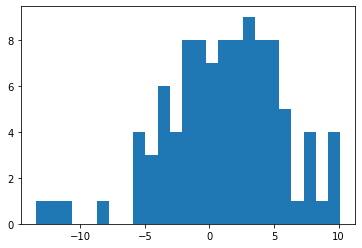

In [274]:
loss, mae, mse = rooms[2]['model'].evaluate(rooms[2]['test_data'], rooms[2]['test_labels'], verbose=2)
test_predictions = rooms[2]['model'].predict(rooms[2]['test_data']).flatten()
error = test_predictions - rooms[2]['test_labels'] 
data = plt.hist(error, bins = 25)

In [272]:
data[1]

array([-13.45270538, -12.50981117, -11.56691696, -10.62402275,
        -9.68112854,  -8.73823433,  -7.79534012,  -6.85244591,
        -5.9095517 ,  -4.96665749,  -4.02376328,  -3.08086906,
        -2.13797485,  -1.19508064,  -0.25218643,   0.69070778,
         1.63360199,   2.5764962 ,   3.51939041,   4.46228462,
         5.40517883,   6.34807304,   7.29096725,   8.23386147,
         9.17675568,  10.11964989])

In [329]:
str(ont.NS['rdf'])

'http://www.w3.org/1999/02/22-rdf-syntax-ns#'

In [378]:
st = '<isl:/damper_sensors/2> <rdf:type> "test file" <file:///> .'
post = st.rfind(' ', 2)
st[:pos]

'<isl:/damper_sensors/2> <rdf:type> "test file" <file:///> '

In [379]:
st.split(' ')

['<isl:/damper_sensors/2>', '<rdf:type>', '"test', 'file"', '<file:///>', '.']

In [385]:
st = ont.g.serialize(format='nquads').decode("utf-8")
lines = st.split('\n')

In [389]:
for line in lines:
    elms = line.split(' ')
    n = len(elms)
    print(' '.join(elms[:n-2]))

<http://inter-space.org/learning_model#/damper_sensors/1> <https://brickschema.org/schema/1.0.3/BrickFrame#isPointOf> <http://inter-space.org/learning_model#/rooms/1>
<http://inter-space.org/learning_model#hasCapacity> <http://www.w3.org/2000/01/rdf-schema#label> "Seating capacity of room"
<http://inter-space.org/learning_model#/damper_sensors/2> <http://www.w3.org/1999/02/22-rdf-syntax-ns#type> <https://brickschema.org/schema/1.0.3/Brick#VAV_Damper_Position_Sensor>
<http://inter-space.org/learning_model#/temperature_sensors/2> <https://brickschema.org/schema/1.0.3/BrickFrame#hasMeasurement> <http://inter-space.org/learning_model#temperature_room_2.csv>
<http://inter-space.org/learning_model#/illuminate_sensors/1> <https://brickschema.org/schema/1.0.3/BrickFrame#hasMeasurement> <http://inter-space.org/learning_model#illuminance_room_1.csv>
<http://inter-space.org/learning_model#/rooms/1> <http://www.w3.org/1999/02/22-rdf-syntax-ns#type> <https://brickschema.org/schema/1.0.3/Brick#Room>

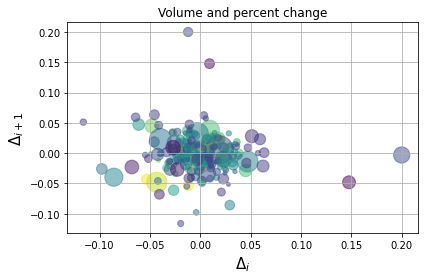

In [410]:
import matplotlib.cbook as cbook

# Load a numpy record array from yahoo csv data with fields date, open, close,
# volume, adj_close from the mpl-data/example directory. The record array
# stores the date as an np.datetime64 with a day unit ('D') in the date column.
price_data = (cbook.get_sample_data('goog.npz', np_load=True)['price_data']
              .view(np.recarray))
price_data = price_data[-250:]  # get the most recent 250 trading days

delta1 = np.diff(price_data.adj_close) / price_data.adj_close[:-1]

# Marker size in units of points^2
volume = (15 * price_data.volume[:-2] / price_data.volume[0])**2
close = 0.003 * price_data.close[:-2] / 0.003 * price_data.open[:-2]

fig, ax = plt.subplots()
ax.scatter(delta1[:-1], delta1[1:], c=close, s=volume, alpha=0.5)

ax.set_xlabel(r'$\Delta_i$', fontsize=15)
ax.set_ylabel(r'$\Delta_{i+1}$', fontsize=15)
ax.set_title('Volume and percent change')

ax.grid(True)
fig.tight_layout()

plt.show()

Text(0, 0.5, 'Models')

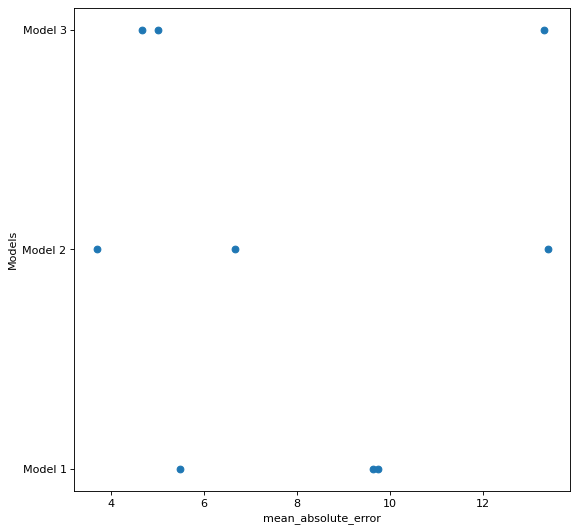

In [487]:
plt.figure(figsize=(8, 8), dpi=80)
plt.scatter(values, models)
plt.xlabel(metric)
plt.ylabel('Models')


In [485]:
#room_id = 1
models = []
values = []
#metric = 'mean_squared_error'
metric = 'mean_absolute_error'
for source_room in rooms:
    
    
    source_model = rooms[source_room]['model']
    
    
    #source_model_id = rooms[source_room]['model_uuid']
    #source_model_filename = f'model/model_{source_model_id}.h5'
    #source_model = tf.keras.models.load_model(source_model_filename)    

    print('---------------')
    # add test evaluations
    for target_room in rooms:
        
        metric_values = source_model.evaluate(rooms[target_room]['test_data'], rooms[target_room]['test_labels'], verbose=0)
        print(metric_values)
        m_ind = 0
        for m in source_model.metrics:
            if m.name == metric:
                models.append(f'Model {source_room}')
                values.append(metric_values[m_ind])
                print(m.name, target_room, metric_values[m_ind])
            m_ind += 1
            
        


---------------
[167.99900817871094, 9.758745193481445, 167.99900817871094]
mean_absolute_error 1 9.758745193481445
[63.64848709106445, 5.497774124145508, 63.64848709106445]
mean_absolute_error 2 5.497774124145508
[129.43197631835938, 9.648994445800781, 129.43197631835938]
mean_absolute_error 3 9.648994445800781
---------------
[327.7085876464844, 13.404314994812012, 327.7085876464844]
mean_absolute_error 1 13.404314994812012
[21.834674835205078, 3.7022125720977783, 21.834674835205078]
mean_absolute_error 2 3.7022125720977783
[65.63717651367188, 6.6768574714660645, 65.63717651367188]
mean_absolute_error 3 6.6768574714660645
---------------
[328.2415771484375, 13.324183464050293, 328.2415771484375]
mean_absolute_error 1 13.324183464050293
[34.17942810058594, 4.665645599365234, 34.17942810058594]
mean_absolute_error 2 4.665645599365234
[40.540653228759766, 5.017570495605469, 40.540653228759766]
mean_absolute_error 3 5.017570495605469


In [463]:
values

[9.758745193481445,
 5.497774124145508,
 9.648994445800781,
 13.404314994812012,
 3.7022125720977783,
 6.6768574714660645,
 13.324183464050293,
 4.665645599365234,
 5.017570495605469]

In [53]:
rooms = {
    1: {'dataset_uuid':  'b782a3a359e54fcebbd57d590665bc39' , 'model_uuid': '0754017c705548d490065f71ac4364ee' },
    2: {'dataset_uuid':  '49117df88973460f947218e5f0adb18e' , 'model_uuid': '24e6a2b6b9c64aec9605bc00b2ed3b5a' },
    3: {'dataset_uuid':  'fa639abdd2e940149afd422aab51e5d8' , 'model_uuid': 'cac90a7b1bf147bda94625edc5b339f7' }
}


for room_id in rooms:
    
    # load model
    model_uuid = rooms[room_id]['model_uuid']
    model_file = f'model/model_{model_uuid}.h5'
    rooms[room_id]['model_file'] = model_file
    rooms[room_id]['model'] = tf.keras.models.load_model(model_file)
    
    # load dataset
    dataset_uuid = rooms[room_id]['dataset_uuid']
    dataset_filename = f'dataset/ds_{dataset_uuid}.h5'
    ds = pd.HDFStore(dataset_filename, 'r')

    test_dataset = ds['test']
    rooms[room_id]['test_data'] = test_dataset
    rooms[room_id]['test_labels'] = test_dataset.pop('occupancy')

    finetune_dataset = ds['finetune']
    rooms[room_id]['finetune_data'] = finetune_dataset
    rooms[room_id]['finetune_labels'] = finetune_dataset.pop('occupancy')
    
    
    
    ds.close()



In [71]:
ont = Ontology()
ont.load_ttl('ontology/base_graph.ttl')

In [72]:
# add dataset and train runs
for room_id, room in rooms.items():
    
    brick_ref = {
        'co2': [
            ('rdf:type', 'brick:CO2_Level'), 
            ('rdfs:label', 'Room CO2 Level'),
            ('brickframe:isMeasuredBy', 'isl:/co2_sensors/'+str(room_id))
        ],
        'occupancy': [
            ('rdf:type', 'brick:Occupancy'),
            ('rdfs:label', 'Room Occupancy'),
            ('brickframe:isMeasuredBy', 'isl:/occ_sensors/'+str(room_id))
        ] 
    }    
    

    ont.add_dataset(room['dataset_uuid'], brick_ref)
    
    
    # add train run
    model_uuid = room['model_uuid']
    
    train_split_id = room['dataset_uuid'] + '/train'
    ont.add_run(room['model_file'], 'occupancy_task', train_split_id)

    
# add test runs (source room model + target room data)
for source_room in rooms:
    
    source_model = rooms[source_room]['model']

    for target_room in rooms:
        
        metric_values = source_model.evaluate(rooms[target_room]['test_data'], rooms[target_room]['test_labels'], verbose=2)
        metric_names = [m.name for m in source_model.metrics]
        metrics = dict(zip(metric_names, metric_values))

        test_split_id = rooms[target_room]['dataset_uuid'] + '/test'
        ont.add_run(rooms[source_room]['model_file'], 'occupancy_task', test_split_id, metrics)    
    

4/4 - 0s - loss: 167.9990 - mean_absolute_error: 9.7587 - mean_squared_error: 167.9990
4/4 - 0s - loss: 63.6485 - mean_absolute_error: 5.4978 - mean_squared_error: 63.6485
4/4 - 0s - loss: 129.4320 - mean_absolute_error: 9.6490 - mean_squared_error: 129.4320
4/4 - 0s - loss: 327.7086 - mean_absolute_error: 13.4043 - mean_squared_error: 327.7086
4/4 - 0s - loss: 21.8347 - mean_absolute_error: 3.7022 - mean_squared_error: 21.8347
4/4 - 0s - loss: 65.6372 - mean_absolute_error: 6.6769 - mean_squared_error: 65.6372
4/4 - 0s - loss: 328.2416 - mean_absolute_error: 13.3242 - mean_squared_error: 328.2416
4/4 - 0s - loss: 34.1794 - mean_absolute_error: 4.6656 - mean_squared_error: 34.1794
4/4 - 0s - loss: 40.5407 - mean_absolute_error: 5.0176 - mean_squared_error: 40.5407


In [73]:
# add fine-tune training run (room 2 model fine-tuned by room 3 data)
model_room_id = 2
ds_room_id = 3

orig_model_id = rooms[model_room_id]['model_uuid']
#new_model_file = f'model/model_{orig_model_id}.h5'
#new_model = tf.keras.models.load_model(new_model_file)

finetuned_model_id = 'b4895793546a4048b0656859e1430349'
finetuned_model_file = f'model/model_{finetuned_model_id}.h5'
finetuned_model = tf.keras.models.load_model(finetuned_model_file)

train_split_id = rooms[ds_room_id]['dataset_uuid'] + '/finetune'
test_split_id = rooms[ds_room_id]['dataset_uuid'] + '/test'

# add training run
ont.add_run(finetuned_model_file, 'occupancy_task', train_split_id, built_on = orig_model_id)

# evaluate new fine-tuned model for room 3 test data
metric_values = finetuned_model.evaluate(rooms[ds_room_id]['test_data'], rooms[ds_room_id]['test_labels'], verbose=2)
metric_names = [m.name for m in finetuned_model.metrics]
metrics = dict(zip(metric_names, metric_values))

# add test evaluation of fine-tuned model to ontology
ont.add_run(finetuned_model_file, 'occupancy_task', test_split_id, metrics) 


4/4 - 0s - loss: 52.9462 - mean_absolute_error: 5.6570 - mean_squared_error: 52.9462


rdflib.term.URIRef('http://inter-space.org/learning_model#run_cf4055c34d284efcb0597d5f3f22df83')

In [76]:
ont.save('building_model_1.nq')

In [75]:
ont.save('building_model_1.ttl')